In [ ]:
# https://github.com/sun1638650145/Libraries-and-Extensions-for-TensorFlow-for-Apple-Silicon/releases/tag/v2.15
# https://www.kaggle.com/code/antoinebertin/bert-text-classification/edit
# pip3 install PATH.whl

In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import  Dense,Dropout
import tensorflow_text as text
import tensorflow_hub as hub
from tensorflow.keras.metrics import Precision, Recall , SparseCategoricalAccuracy 
import tensorflow as tf
import matplotlib.pyplot as plt 
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report

In [11]:
df = pd.read_csv("/Users/antoinebertin/Documents/jedha/full_stack/projects_full_stack/spam/df.csv")

In [12]:
df.drop(columns=['v1', 'v2', 'v2_encoded'], inplace=True)

In [13]:
df.head()

,encoding,v2_clean
0,0,jurong point crazy available bugis great world...
1,0,ok lar joke wif oni
2,1,free entry wkly comp win fa cup final tkts 21s...
3,0,dun early hor
4,0,nah think usf live


# Split

In [14]:
# ensure v2_clean is all str
df['v2_clean'] = df['v2_clean'].apply(lambda x: str(x))

In [15]:
X_train, X_val, y_train, y_val = train_test_split(df['v2_clean'], df['encoding'], test_size=0.2, random_state=42)

In [16]:
print(X_train.shape, X_val.shape, y_train.shape, y_val.shape )

(4457,) (1115,) (4457,) (1115,)


# Modeling

In [3]:
text_input = tf.keras.layers.Input(shape=(), dtype=tf.string)
preprocessor = hub.KerasLayer(
    "https://www.kaggle.com/models/tensorflow/bert/frameworks/TensorFlow2/variations/en-uncased-preprocess/versions/3")
encoder_inputs = preprocessor(text_input)

In [4]:
encoder = hub.KerasLayer(
    "https://www.kaggle.com/models/tensorflow/bert/frameworks/TensorFlow2/variations/en-uncased-l-12-h-768-a-12/versions/4",
    trainable=False)
outputs = encoder(encoder_inputs)
pooled_output = outputs["pooled_output"]      # [batch_size, 768].
sequence_output = outputs["sequence_output"]  # [batch_size, seq_length, 768].

# Fine Tuning & model construction

In [5]:
l = tf.keras.layers.Dense(128, activation='relu', name='h1')(pooled_output)
l = tf.keras.layers.Dense(64, activation='relu',name='h2')(l)
l = tf.keras.layers.Dense(32, activation='relu', name='h3')(l)
l = tf.keras.layers.Dense(16, activation='relu', name='h4')(l)
l = tf.keras.layers.Dense(1,activation='sigmoid',name='output')(l)

In [6]:
model=tf.keras.Model(inputs=[text_input],outputs=[l])

In [7]:
# Compile the model

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy',Precision(), Recall()])

In [8]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None,)]                    0         []                            
                                                                                                  
 keras_layer (KerasLayer)    {'input_type_ids': (None,    0         ['input_1[0][0]']             
                             128),                                                                
                              'input_mask': (None, 128)                                           
                             , 'input_word_ids': (None,                                           
                              128)}                                                               
                                                                                              

# Train the last layer

In [54]:
hist = model.fit(X_train, y_train, epochs=5,batch_size=32 ,validation_data=(X_val, y_val))

Epoch 1/5
140/140 [==============================] - 318s 2s/step - loss: 0.2688 - accuracy: 0.8957 - precision: 0.7426 - recall: 0.3384 - val_loss: 0.1641 - val_accuracy: 0.9283 - val_precision: 0.8977 - val_recall: 0.5267
Epoch 2/5
140/140 [==============================] - 318s 2s/step - loss: 0.1302 - accuracy: 0.9551 - precision: 0.8724 - recall: 0.7789 - val_loss: 0.1020 - val_accuracy: 0.9686 - val_precision: 0.9078 - val_recall: 0.8533
Epoch 3/5
140/140 [==============================] - 322s 2s/step - loss: 0.1121 - accuracy: 0.9616 - precision: 0.8959 - recall: 0.8074 - val_loss: 0.1285 - val_accuracy: 0.9543 - val_precision: 0.9901 - val_recall: 0.6667
Epoch 4/5
140/140 [==============================] - 322s 2s/step - loss: 0.1104 - accuracy: 0.9632 - precision: 0.8944 - recall: 0.8224 - val_loss: 0.0907 - val_accuracy: 0.9731 - val_precision: 1.0000 - val_recall: 0.8000
Epoch 5/5
140/140 [==============================] - 325s 2s/step - loss: 0.0991 - accuracy: 0.9668 - pr

In [61]:
model.save("bert.keras")

# Evaluation

In [55]:
hist.history.keys()

dict_keys(['loss', 'accuracy', 'precision', 'recall', 'val_loss', 'val_accuracy', 'val_precision', 'val_recall'])

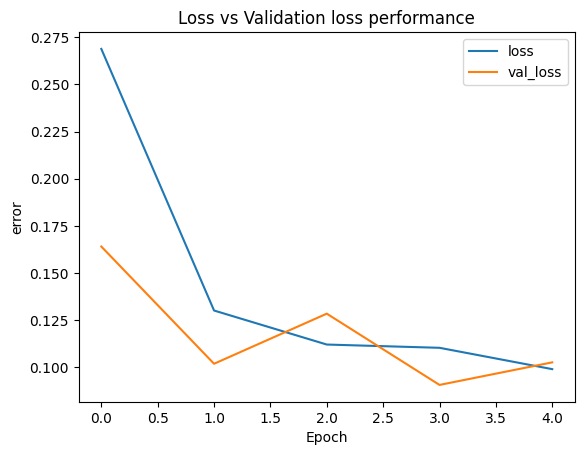

In [56]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.legend(['loss','val_loss'])
plt.title('Loss vs Validation loss performance')
plt.xlabel('Epoch')
plt.ylabel('error')
plt.show()

In [57]:
model.evaluate(X_val, y_val)

35/35 [==============================] - 65s 2s/step - loss: 0.1027 - accuracy: 0.9632 - precision: 0.9910 - recall: 0.7333


[0.10269901156425476,
 0.963228702545166,
 0.9909909963607788,
 0.7333333492279053]

In [58]:
y_predict=model.predict(X_val)
y_pred=np.where(y_predict>0.5,1,0)

35/35 [==============================] - 65s 2s/step


In [59]:
cr = classification_report(y_val, y_pred)
print(cr)

              precision    recall  f1-score   support

           0       0.96      1.00      0.98       965
           1       0.99      0.73      0.84       150

    accuracy                           0.96      1115
   macro avg       0.98      0.87      0.91      1115
weighted avg       0.96      0.96      0.96      1115



In [60]:
# Generate a confusion matrix
conf_matrix = confusion_matrix(y_val, y_pred)

# Print the confusion matrix
print("Confusion Matrix:\n", conf_matrix)

Confusion Matrix:
 [[964   1]
 [ 40 110]]


# Test for fun

In [20]:
from tensorflow.keras.models import load_model

In [25]:
model = load_model('bert.keras', custom_objects={'KerasLayer': hub.KerasLayer})

In [17]:
X_val

3245    funny fact teach volcanoes erupt tsunamis aris...
944     send score sophas secondary application school...
1044           fancy 09058097218 find pobox 6 ls15hb 150p
2484                  promise soon ll text morning let ok
812     congratulation award å£500 cd gift voucher fre...
                              ...                        
4264    ltdecimalgt common car buy china asia find exp...
2439                    rightio 1148 bright early morning
5556                                 yes texte pshewmisse
4205                                                 door
4293    kit strip bill 150p netcollex ltd po box 1013 ...
Name: v2_clean, Length: 1115, dtype: object

In [27]:
text = ["Buy now my new book"]

In [28]:
model.predict(text)

1/1 [==============================] - 0s 486ms/step


array([[0.00339883]], dtype=float32)